In [222]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The recursive Green's function method relies on these two equations:
$$ \check{G}^{L}_{j} = \left[ i\omega_{p} \check{1} - \check{H}^{0}_{j} - \check{T}^{+}_{j}\check{G}^{L}_{j-1} \check{T}^{-}_{j} \right]^{-1} $$
starting at $j = j_{L}$, which is some slice in the left lead,
$$ \check{G}^{R}_{j} = \left[ i\omega_{p} \check{1} - \check{H}^{0}_{j} - \check{T}^{-}_{j+1}\check{G}^{R}_{j+1} \check{T}^{+}_{j + 1} \right]^{-1} $$
starting at $j = j_{R}$ which is some slice in the right lead,
and finally:
$$\check{G}_{\omega_{p}}(j , j) = \left[ i\omega_{p} \check{1} -  \check{H}^{0}_{j} - \check{T}^{-}_{j+1}\check{G}^{R}_{j+1} \check{T}^{+}_{j + 1}  - \check{T}^{+}_{j}\check{G}^{L}_{j-1} \check{T}^{-}_{j} \right] $$
An upside down hat means its a $(2W \times 2W)$ matrix. $\check{T}^{+}_{j}$ is the matrix that shifts you to the right from site $j$, whilst $\check{T}^{-}_{j}$ shifts you to the left from site $j$. Also $\check{G}^{L/R}_{j} = \check{G}_{\omega_{P}}(j , j)$ which is the Green's function of the system in which all alttice site $j'\geq j+1$ and $j' \leq j - 1$ are deleted.
These means we will first have to evaluate $\check{G}^{L}_{j_{L}-1}$ and $\check{G}^{R}_{j_{R} + 1}$, which this paper tells me how to do numerically: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.44.8017. Probably best to evaluate this numerically since these Green's functions are only analytically soluble in the simplest of cases (i.e. s-wave disorderless superconductors).


From the Ando paper I learned that I should first calculate all modes in the ideal superconducting leads. This should give me a matrix of eigenvectors $U(\pm)$ (where $+$ corresponds to right moving and $-$ corresponds to left-moving) and a diagonal matrix of eigenvalues $\Lambda(\pm)$. We can determine whether they are rightr movers or left movers by studying $arg(\Lambda_{ii})$. The important matrix to calculate is:
$$ F(-) = U(-)\Lambda(-)U^{-1}(-)$$ 

To compute all the modes in the lead, I need to solve the following eigenvalue problem:
$$ \underbrace{\begin{pmatrix} - [\check{T}^{-}]^{-1}(\check{H}^{j}_0 - E) & -[\check{T}^{-}]^{-1}\check{T}^{+} \\ \check{1} & \check{0} \end{pmatrix}}_{\mathbb{M}}\begin{pmatrix}\vec{c}_{j} \\ \vec{c}_{j-1} \end{pmatrix} = \lambda \begin{pmatrix}\vec{c}_{j} \\ \vec{c}_{j-1} \end{pmatrix} $$
where $\check{H}^{j}_{0}$ is the onsite Hamiltonian of slice $j$ and $\vec{c}_{j}$ is the vector of amplitudes on slice $j$. The argument of $\lambda$ will give the direction of current between slice $j -1$ and slice $j$.

In [313]:
from dataclasses import dataclass
from RGFtools import *
@dataclass
class JosephsonParameters:
    W : int
    L : int
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float

params = JosephsonParameters(W = 2 , 
                             L = 10,
                             t = 1,
                             flux = 0,
                             energy = 0.0,
                             Delta = 0,
                             phase = 0,
                             mu = 0.5)
    

In [317]:
F_pos_0 , F_neg_0 , debug0 = calculate_transfer_matrices(0 , params)
F_pos_Lplusone , F_neg_Lplusone , debug_Lplusone = calculate_transfer_matrices(params.L+1 , params)

# Initial diagonal Green's function in the left-lead at slice 0:
H_0_tilde = h_0(slice , params) - T(slice , -1 , params)@np.linalg.inv(F_neg_0)
G_0 = np.linalg.inv(params.energy - (H_0_tilde))

H_Lplusone_tilde = h_0(params.L+1 , params) - T(params.L+2 , +1 , params)@F_pos_Lplusone
G_Lplusone = np.linalg.inv(params.energy - (H_Lplusone_tilde))

# Recursion:

no_steps = params.L + 2
diag_greensfunctions = np.zeros(shape = (2*params.W , 2*params.W , no_steps))
off_diag_greensfunctions = np.zeros(shape = (2*params.W , 2*params.W , no_steps))
# Initial condition:
diag_greensfunctions[: , : , 0] = G_0
off_diag_greensfunctions[: , : , 0] = G_0
for i in range(no_steps):
    if i > 0:
        diag_greensfunctions[: , : , i] = np.linalg.inv(params.energy*np.identity(2*params.W) - h_0(i , params) -
                                                    T(i , +1 , params)@diag_greensfunctions[: , : , 0]@T(i , -1 , params))
        off_diag_greensfunctions[: , : , i] = diag_greensfunctions[: , : , i]@T(i , +1 , params)@ off_diag_greensfunctions[: , : , i-1]

## Transmission matrix:
U_pos = debug0['U_pos']
U_neg = debug0['U_neg']
transmissionmatrix = np.linalg.inv(U_pos)@off_diag_greensfunctions[: , : , -1]@T(0 , +1 , params)@(np.linalg.inv(F_pos_0) - 
                                                                                                   np.linalg.inv(F_neg_0))@U_pos

reflectionmatrix = np.linalg.inv(U_neg)@(diag_greensfunctions[: , : , 0]@T(0 , +1 , params)@(np.linalg.inv(F_pos_0) - 
                                                                                                   np.linalg.inv(F_neg_0)) - np.identity(U_neg.shape[0]))@U_pos

conductance = (np.linalg.norm(transmissionmatrix))**2
alternative_conductance = 1 - (np.linalg.norm(reflectionmatrix))**2
print(conductance)
print(alternative_conductance)

1.0542606659824261e-07
-0.17831210193982083


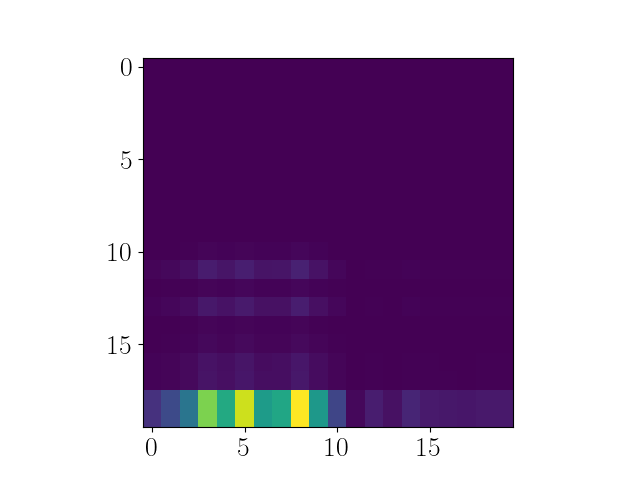

In [299]:
fig , ax = plt.subplots()
ax.imshow(np.abs(transmissionmatrix))

(40, 4)
(40, 4)
(40, 16)
(40, 16)


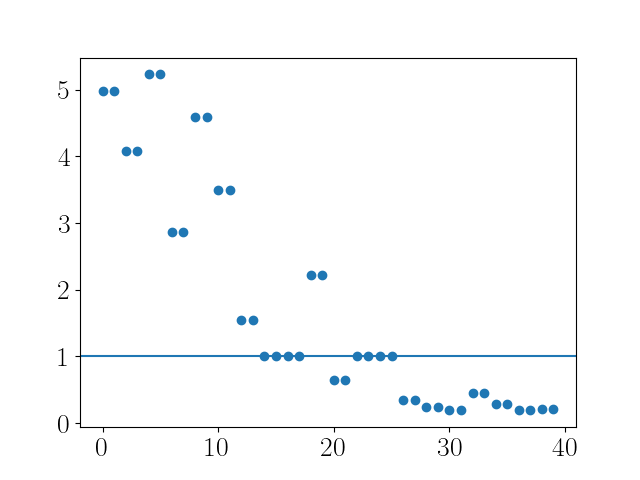

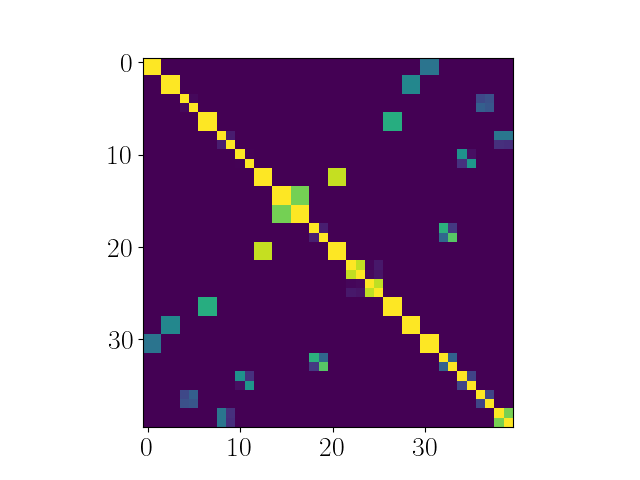

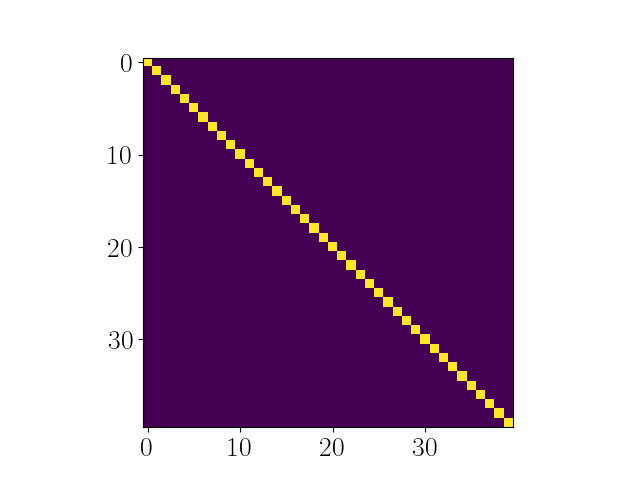

In [300]:
evals0 = debug0['evals']
print(debug0['pos_prop'].shape)
print(debug0['neg_prop'].shape)
print(debug0['pos_evanesce'].shape)
print(debug0['neg_evanesce'].shape)


plt.figure()
plt.scatter(np.arange(len(evals0)) , np.abs(evals0))
plt.axhline(y = 1)

# checking normalisation of eigenmodes at j = 0:
evecs = debug0['evecs']#[0 : int(debug0['evecs'].shape[0]) , :]
from scipy.linalg import orth
evecs_orth = orth(evecs)
norm = np.conjugate(evecs.T)@evecs
norm_orth = np.conjugate(evecs_orth.T)@evecs_orth

plt.figure()
plt.imshow(np.abs(norm))

plt.figure()
plt.imshow(np.abs(norm_orth))